In [173]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage import metrics as skmetrics
import lpips
import torch
import cv2
import glob
import tqdm
import json
from sklearn import mixture
from scipy.stats import norm

In [174]:
def align_images(ref, fore):
    # Convert images to grayscale
    ref_gray = cv2.cvtColor((ref * 255).clip(0,255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    fore_gray = cv2.cvtColor((fore * 255).clip(0,255).astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Use ORB (Oriented FAST and Rotated BRIEF) to detect and compute keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(ref_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(fore_gray, None)

    # Use the BFMatcher to find the best matches between the descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort the matches based on their distances
    matches = sorted(matches, key=lambda x: x.distance)

    # Get the corresponding points in both images
    ref_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    fore_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Use the RANSAC algorithm to estimate an affine transformation
    M, _ = cv2.estimateAffinePartial2D(fore_points, ref_points)

    # Apply the transformation to the fore image
    aligned_fore = cv2.warpAffine(fore, M, (ref.shape[1], ref.shape[0]))
    # convert to RGB
    # aligned_fore = cv2.cvtColor(aligned_fore, cv2.COLOR_BGR2RGB)
    # convert ref to RGB
    # ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
    
    refCopy = ref.copy()
    mask = aligned_fore.sum(2) == 0
    mask = cv2.dilate(mask.astype(np.uint8), np.ones((3, 3), np.uint8), iterations=1).astype(bool)
    refCopy[~mask] = aligned_fore[~mask]



    return refCopy

def get_result(img_id, method):
    if method == "baseline":
        img = plt.imread(f"baseline/results/{img_id}.png")[:,:,:3]
    elif method == "ShadowGP":
        img = plt.imread(f"ShadowGP/extracted_results/{img_id}-output.png")[:,:,:3]
    elif method == "BlindShadowRemoval":
        img = plt.imread(f"BlindShadowRemoval/test/{img_id.split('-')[0]}_{img_id}-result.png")[:,:,:3]
        img = img[:236, 1280:1516, :]
        gt = plt.imread(f"gt/{img_id}.png")[:,:,:3]
        img = align_images(gt, img)
    elif method == "classical":
        img = plt.imread(f"classical/results/{img_id}.png")[:,:,:3]
    else:
        return ValueError("Method not implemented")
    if img.dtype == np.uint8:
        img = img / 255
    return img

In [142]:
lpips_loss_fn = lpips.LPIPS(net='alex')
img_ids = [path.split("/")[1].split(".")[0] for path in glob.glob("gt/*.png")]
results = {}
for img_id in tqdm.tqdm(img_ids):
    gt = plt.imread(f"gt/{img_id}.png")[:,:,:3]
    for method in ["baseline", "ShadowGP", "BlindShadowRemoval", "classical"]:
        try:
            result = get_result(img_id, method)
            ssim = skmetrics.structural_similarity(gt, result, data_range=1, channel_axis=2)
            lpips_loss = lpips_loss_fn.forward(torch.tensor(gt).permute(2,0,1), torch.tensor(result).permute(2,0,1)).item()
            if method not in results:
                results[method] = {}
            results[method][img_id] = {"ssim": float(ssim), "lpips": float(lpips_loss)}
        except Exception as e:
            print(e)
# save results as json with pretty formatting
with open("results.json", "w") as f:
    json.dump(results, f, indent=2, sort_keys=True)

baseline: SSIM=0.6652, LPIPS=0.1526
ShadowGP: SSIM=0.7305, LPIPS=0.1084
BlindShadowRemoval: SSIM=0.7827, LPIPS=0.1346
classical: SSIM=0.7566, LPIPS=0.1167


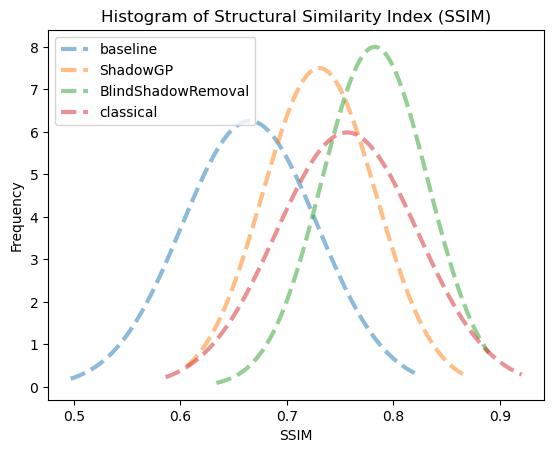

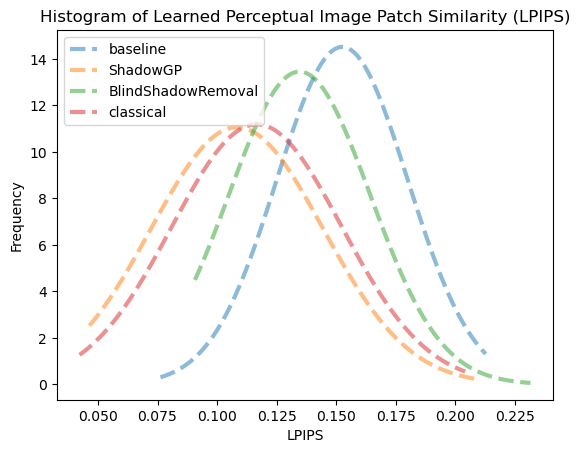

In [172]:
for method in ["baseline", "ShadowGP", "BlindShadowRemoval", "classical"]:
    ssim = np.mean([results[method][img_id]["ssim"] for img_id in results[method]])
    lpips = np.mean([results[method][img_id]["lpips"] for img_id in results[method]])
    print(f"{method}: SSIM={ssim:.4f}, LPIPS={lpips:.4f}")

# create histogram of SSIM for each method
plt.figure()
hatch_patterns = ["///", "\\\\\\\\", "ooo", "***", ".", "*", "+"]
for i,method in enumerate(["baseline", "ShadowGP", "BlindShadowRemoval", "classical"]):
    ssims = [results[method][img_id]["ssim"] for img_id in results[method]]
    hist, bins = np.histogram(ssims, bins=20)
    # fit a normal distribution to the data
    model = sklearn.mixture.GaussianMixture(n_components=1).fit(np.array(ssims).reshape(-1,1))
    mean_ = model.means_[0]
    std_ = np.sqrt(model.covariances_[0])[0]
    # plot normal distribution
    x = np.linspace(bins[0], bins[-1], 100)
    plt.plot(x, norm.pdf(x, mean_, std_), label=method, linestyle="--", linewidth=3, color=f"C{i}", alpha=0.5)

plt.title("Histogram of Structural Similarity Index (SSIM)")
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# create histogram of LPIPS for each method
plt.figure()
hatch_patterns = ["///", "\\\\\\\\", "ooo", "***", ".", "*", "+"]
for i,method in enumerate(["baseline", "ShadowGP", "BlindShadowRemoval", "classical"]):
    lpips = [results[method][img_id]["lpips"] for img_id in results[method]]
    hist, bins = np.histogram(lpips, bins=20)
    # fit a normal distribution to the data
    model = sklearn.mixture.GaussianMixture(n_components=1).fit(np.array(lpips).reshape(-1,1))
    mean_ = model.means_[0]
    std_ = np.sqrt(model.covariances_[0])[0]
    # plot normal distribution
    x = np.linspace(bins[0], bins[-1], 100)
    plt.plot(x, norm.pdf(x, mean_, std_), label=method, linestyle="--", linewidth=3, color=f"C{i}", alpha=0.5)

plt.title("Histogram of Learned Perceptual Image Patch Similarity (LPIPS)")
plt.xlabel("LPIPS")
plt.ylabel("Frequency")
plt.legend()
plt.show()